<a href="https://colab.research.google.com/github/YaZlob/ML_project/blob/master/Learn_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этой работе представлены:

*   Сжимающий автоэкнодер с помощью сверточных слоев
*   Denoising автоэнкодер, убирающий шум с изображений
*   Denoising автоэнкодер для гладкой функции
 



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from copy import deepcopy
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

cuda


Загрузка датасета MNIST

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor()])

batch_size = 32
trainset = torchvision.datasets.MNIST(root='./dataset', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./dataset', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = [i for i in range(10)]

KeyboardInterrupt: ignored

Функция для отрисовки изображений

In [ ]:
def print_data(dataloader,im_count=9):
  fig = plt.figure(figsize=(9,9))
  random_index = np.random.randint(0, len(dataloader),size=im_count)
  
  for i in range(im_count):
    # part of predict neural network
    a = fig.add_subplot(3, 3, i + 1)
    image, label = dataloader.dataset[random_index[i]]
    image = transforms.ToPILImage(mode='L')(image)
    plt.imshow(image,cmap = "gray")
    a.set_title(f"{label}")

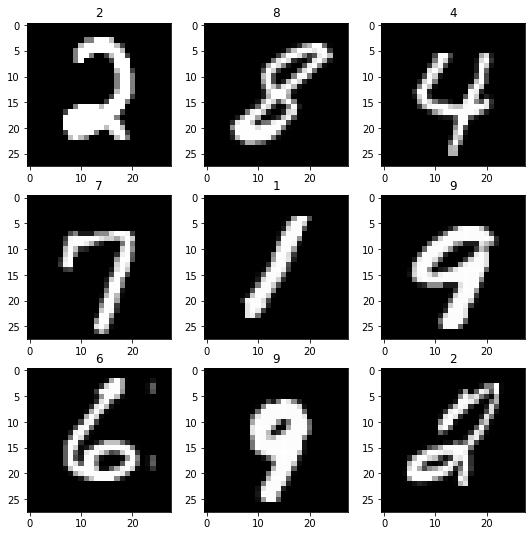

In [ ]:
print_data(trainloader)

Реализация простой модели сжимающиего автоэнкодера (создаем свой jpg)

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self):
        super(AutoEncoder, self).__init__()

        #Encoder
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size=3)
        self.pool1 = nn.MaxPool2d((2,2)) #->12x12

        self.conv2 = nn.Conv2d(in_channels=6,out_channels = 16, kernel_size = 3)
        self.pool2 = nn.MaxPool2d((2,2)) # ->5x5


        # Code
        self.code = nn.Conv2d(in_channels=16,out_channels=16,kernel_size=(1,1))

        #Decoder
        self.upsample1 = nn.UpsamplingBilinear2d(size = 10)
        self.decode1 = nn.ConvTranspose2d(in_channels=16,out_channels=8,kernel_size=3)
        self.upsample2 = nn.UpsamplingBilinear2d(size = 26)
        self.decode2 = nn.ConvTranspose2d(in_channels=8, out_channels = 1, kernel_size=3)



  def forward(self,x):
      x.to(device)
      x = self.pool1(F.relu(self.conv1(x)))
      x = self.pool2(F.relu(self.conv2(x)))
      x = F.sigmoid(self.code(x))
      x = F.relu(self.decode1(self.upsample1(x)))
      x = F.sigmoid(self.decode2((self.upsample2(x))))
      return x

Создание объекта модели. Выбор метрики и алгоритма оптимизации градиентного спуска.

In [ ]:
model = AutoEncoder()
loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Функции для обучения и тестирования модели

In [ ]:
def train_mode(model, criterion, optim, loader):
  train_loss = 0
  model.train()

  for image, label in loader:
    image = image.to(device)
    optim.zero_grad()
    pred = model(image)
    loss = criterion(pred,image)
    loss.backward()
    optim.step()
    train_loss += loss.item()
  return train_loss

def test_mode(model, criterion, loader):
  test_loss = 0
  model.eval()
  for image, label in loader:
    image = image.to(device)
    with torch.set_grad_enabled(False):
      pred = model(image)
      loss = criterion(pred,image)
    test_loss += loss.item() 
    
  return test_loss
  

Функция, реализующая цикл обучения модели

In [9]:
def loop(model, criterion, optim, train_loader, test_loader, num_epochs):
  hist = []
  for epoch in (range(num_epochs)):
    train = train_mode(model, criterion, optim, train_loader)
    test = test_mode(model, criterion, test_loader)
    print(f"iteration number:{epoch + 1}")
    print("train loss: {:.5f} | test loss: {:.5f}".format(train, test))
    hist.append((train,test))
    
  return hist

In [ ]:
hist = loop(model.to(device),loss_func, optimizer, trainloader,testloader,10)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train loss: 338.27324 | test loss: 43.79008
train loss: 248.49023 | test loss: 39.46793
train loss: 232.04128 | test loss: 37.56437
train loss: 224.30042 | test loss: 36.72813
train loss: 219.45814 | test loss: 35.87257
train loss: 216.01246 | test loss: 35.31898
train loss: 212.93814 | test loss: 34.92344
train loss: 210.81111 | test loss: 34.57255
train loss: 209.01126 | test loss: 34.78399
train loss: 207.58523 | test loss: 34.07179


Для наглядности представления обучения необходима функция, показывающая обучение модели

In [11]:
def show_graph(hist):
    train_loss,test_loss = [], []
    for train,test in hist:
        train_loss.append(train)
        test_loss.append(test)
    plot1 = plt.figure(1)
    plt.plot(train_loss)

    plot2 = plt.figure(2)
    plt.plot(test_loss)

    plt.show()

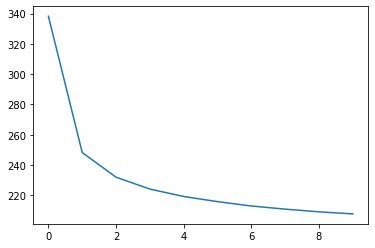

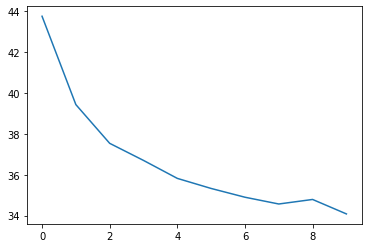

In [ ]:
show_graph(hist)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train loss: 206.03567 | test loss: 33.95133
train loss: 205.55630 | test loss: 33.87264
train loss: 205.15052 | test loss: 33.82581
train loss: 204.73112 | test loss: 33.73342
train loss: 204.33728 | test loss: 33.80512
train loss: 204.02043 | test loss: 33.65196
train loss: 203.65332 | test loss: 33.63266
train loss: 203.36545 | test loss: 33.50337
train loss: 203.00350 | test loss: 33.51717
train loss: 202.72830 | test loss: 33.42126
train loss: 202.42959 | test loss: 33.38082
train loss: 202.16950 | test loss: 33.33584
train loss: 201.93017 | test loss: 33.25484
train loss: 201.68130 | test loss: 33.25732
train loss: 201.43398 | test loss: 33.22308
train loss: 201.22393 | test loss: 33.14828
train loss: 201.00212 | test loss: 33.13059
train loss: 200.78294 | test loss: 33.08597
train loss: 200.61259 | test loss: 33.08686
train loss: 200.38914 | test loss: 33.04587


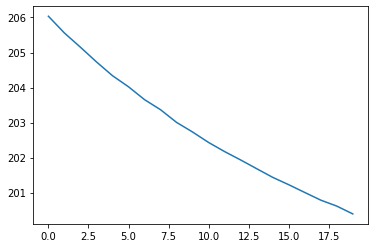

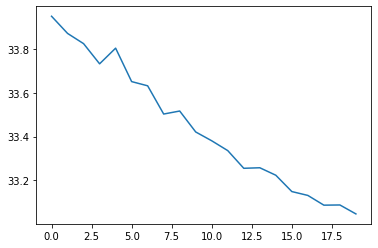

In [ ]:
# уменьшим lr, запустим обучаться модель еще на 20 итерациях
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
hist = loop(model,loss_func, optimizer, trainloader,testloader,20)
show_graph(hist)

In [ ]:
def check_model_work(model,dataloader):
  plt.figure(figsize=(18, 6))
  random_index = np.random.randint(0, len(dataloader),size=5)
  for i in range(5):
    image, label = dataloader.dataset[random_index[i]]
    im_for_model = deepcopy(image)
    image = transforms.ToPILImage(mode='L')(image)
    plt.subplot(2, 5, i+1)
    plt.axis("off")
    plt.title(f"{label}")
    plt.imshow(image,cmap = "gray")
    
    image = model(im_for_model.unsqueeze(0))
    image = transforms.ToPILImage(mode='L')(image[0])
    plt.subplot(2, 5, i+6)
    plt.axis("off")
    plt.title(f"{label}")
    plt.imshow(image,cmap = "gray")
  plt.show();

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


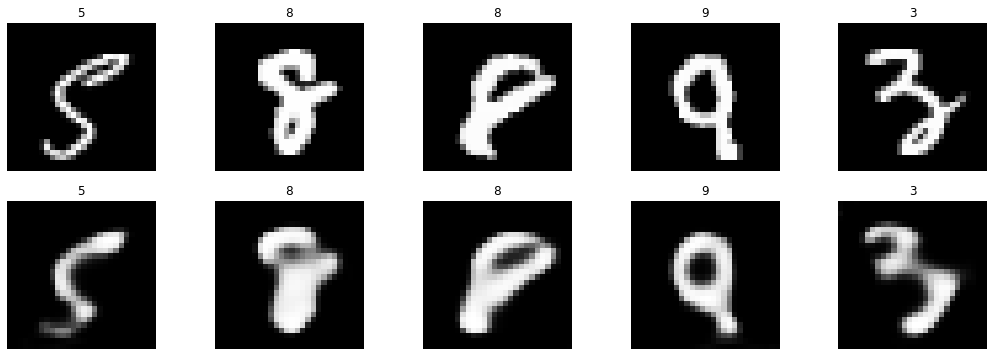

In [ ]:
check_model_work(model.cpu(),testloader)

Точность модели можно увеличить, если продолжить обучение еще несколько итераций. Можно изменить lr, изменить количество итеараций, чтобы посмотреть как это повлияет на обучение модели. Я остановлюсь на этом результате, так как убедился, что классические алгоритмы сжатия работают лучше, чем сжимающий автоэнкодер

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train loss: 201.27909 | test loss: 33.16907
train loss: 201.01898 | test loss: 33.14217
train loss: 200.73713 | test loss: 33.10162
train loss: 200.50084 | test loss: 33.11732
train loss: 200.24393 | test loss: 33.01812
train loss: 200.00434 | test loss: 32.95705
train loss: 199.76408 | test loss: 32.92185
train loss: 199.50583 | test loss: 32.88905
train loss: 199.32179 | test loss: 32.85866
train loss: 199.07871 | test loss: 32.83076


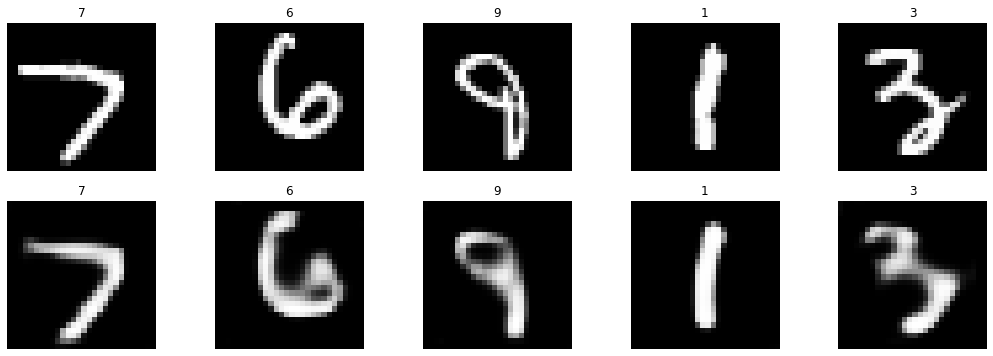

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
hist = loop(model.to(device),loss_func, optimizer, trainloader,testloader,10)
check_model_work(model.cpu(),testloader)

Denoising AutoEncoder

In [ ]:
def add_noise(tensor,mean=0.5,std=0.2):
    tensor_with_noise = tensor + torch.empty(tensor.shape).normal_(mean=mean,std=std)
    return torch.clip(tensor_with_noise,min = 0, max = 1)

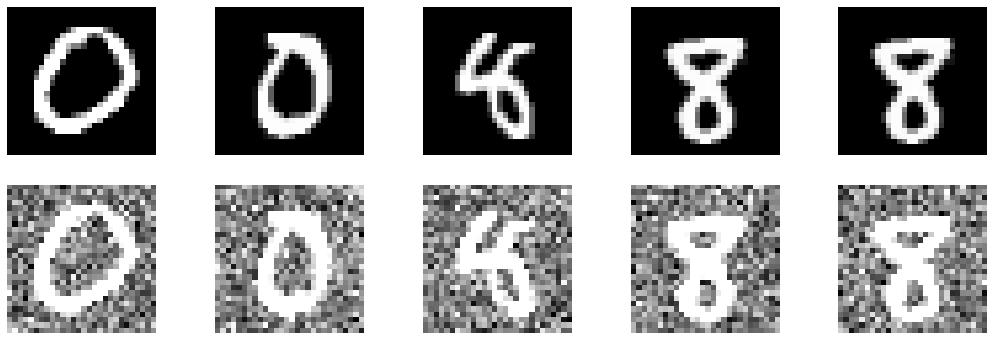

In [ ]:
def check_noise_work(dataloader,noiser):
  plt.figure(figsize=(18, 6))
  random_index = np.random.randint(0, len(dataloader),size=5)
  for i in range(5):
    image, label = dataloader.dataset[random_index[i]]
    noise_image = noiser(image)

    image = transforms.ToPILImage(mode='L')(image)
    plt.subplot(2, 5, i+1)
    plt.axis("off")
    plt.imshow(image,cmap = "gray")

    noise_image = transforms.ToPILImage(mode='L')(noise_image)
    plt.subplot(2, 5, i+6)
    plt.axis("off")
    plt.imshow(noise_image,cmap = "gray")
  plt.show();
check_noise_work(testloader,add_noise)

In [ ]:
class NoiseAutoEncoder(nn.Module):
  def __init__(self):
        super(NoiseAutoEncoder, self).__init__()

        #Encoder
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(2,2)

        #Decoder
        self.upsample1 = nn.UpsamplingBilinear2d(size = 5)
        self.decode1 = nn.ConvTranspose2d(in_channels=32,out_channels=16,kernel_size=3)
        self.upsample2 = nn.UpsamplingBilinear2d(size = 12)
        self.decode2 = nn.ConvTranspose2d(in_channels=16, out_channels = 8, kernel_size=3)
        self.upsample3 = nn.UpsamplingBilinear2d(size = 24)
        self.decode3 = nn.ConvTranspose2d(in_channels = 8, out_channels = 4, kernel_size=3)
        self.final_layer = nn.ConvTranspose2d(in_channels = 4, out_channels = 1, kernel_size=3)


  def forward(self,x):
      x.to(device)
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = self.pool(F.relu(self.conv3(x)))
      x = F.relu(self.decode1(self.upsample1(x)))
      x = F.relu(self.decode2(self.upsample2(x)))
      x = F.relu(self.decode3(self.upsample3(x)))
      x = F.sigmoid(self.final_layer(x))
      return x

In [ ]:
def train_mode_with_noise(model, criterion, optim, loader):
  train_loss = 0
  model.train()
  for image, label in loader:
    # add noise to image
    noise_image = add_noise(image).to(device)
    image = image.to(device)
    optim.zero_grad()
    pred = model(noise_image)
    loss = criterion(pred,image)
    loss.backward()
    optim.step()
    train_loss += loss.item()
  return train_loss

def loop1(model, criterion, optim, train_loader, test_loader, num_epochs):
  hist = []
  for epoch in (range(num_epochs)):
    train = train_mode_with_noise(model, criterion, optim, train_loader)
    test = test_mode(model, criterion, test_loader)
    print(f"iteration number:{epoch + 1}")
    print("train loss: {:.5f} | test loss: {:.5f}".format(train, test))
    hist.append((train,test))
    
  return hist

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


iteration number:1
train loss: 90.64648 | test loss: 15.23530
iteration number:2
train loss: 51.05382 | test loss: 11.96170
iteration number:3
train loss: 42.73667 | test loss: 10.49058
iteration number:4
train loss: 38.46834 | test loss: 10.65909
iteration number:5
train loss: 35.57619 | test loss: 9.47428
iteration number:6
train loss: 33.47451 | test loss: 9.74449
iteration number:7
train loss: 31.82182 | test loss: 9.64313
iteration number:8
train loss: 30.32392 | test loss: 9.48325
iteration number:9
train loss: 29.08081 | test loss: 9.97666
iteration number:10
train loss: 28.07145 | test loss: 11.31991


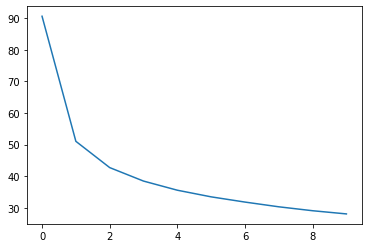

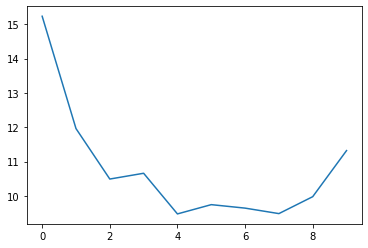

In [ ]:
noise_model = NoiseAutoEncoder()
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(noise_model.parameters(), lr=1e-3)
hist = loop1(noise_model.to(device),loss_func, optimizer, trainloader,testloader,10)
show_graph(hist)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


iteration number:1
train loss: 26.80349 | test loss: 10.47538
iteration number:2
train loss: 26.53894 | test loss: 11.01175
iteration number:3
train loss: 26.27846 | test loss: 10.92065
iteration number:4
train loss: 26.05810 | test loss: 10.99157
iteration number:5
train loss: 25.83496 | test loss: 10.92049
iteration number:6
train loss: 25.60542 | test loss: 11.58910
iteration number:7
train loss: 25.38468 | test loss: 11.50972
iteration number:8
train loss: 25.31142 | test loss: 11.20509
iteration number:9
train loss: 25.16778 | test loss: 11.40910
iteration number:10
train loss: 24.97551 | test loss: 11.21987
iteration number:11
train loss: 24.90177 | test loss: 11.35177
iteration number:12
train loss: 24.75356 | test loss: 10.85102
iteration number:13
train loss: 24.63615 | test loss: 11.15318
iteration number:14
train loss: 24.53224 | test loss: 10.86674
iteration number:15
train loss: 24.48649 | test loss: 11.18625
iteration number:16
train loss: 24.35728 | test loss: 11.49681
i

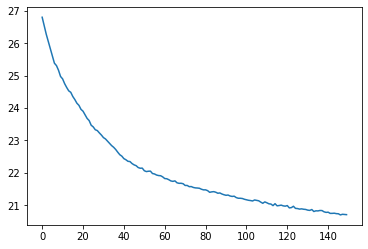

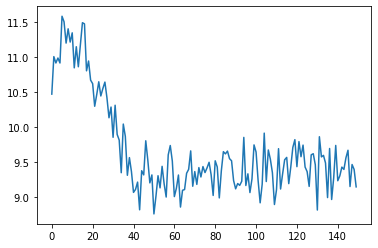

In [ ]:
optimizer = torch.optim.Adam(noise_model.parameters(),lr = 3e-4)
hist = loop1(noise_model.to(device),loss_func, optimizer, trainloader,testloader,40)
show_graph(hist)

In [ ]:
optimizer = torch.optim.Adam(noise_model.parameters(),lr = 1e-4)
hist = loop1(noise_model.to(device),loss_func, optimizer, trainloader,testloader,20)
show_graph(hist)

In [ ]:
def check_model_work(model,dataloader):
  plt.figure(figsize=(18, 6))
  random_index = np.random.randint(0, len(dataloader),size=5)
  for i in range(5):
    #pure image
    image, label = dataloader.dataset[random_index[i]]
    im_for_model = add_noise(image)
    image = transforms.ToPILImage(mode='L')(image)
    plt.subplot(3, 5, i+1)
    plt.axis("off")
    plt.title(f"{label}")
    plt.imshow(image,cmap = "gray")
    #noised image
    noised_image =  transforms.ToPILImage(mode='L')(im_for_model)
    plt.subplot(3, 5, i+6)
    plt.axis("off")
    plt.title(f"{label}")
    plt.imshow(noised_image,cmap = "gray")
    #image from model
    image = model(im_for_model.unsqueeze(0))
    image = transforms.ToPILImage(mode='L')(image[0])
    plt.subplot(3, 5, i+11)
    plt.axis("off")
    plt.title(f"{label}")
    plt.imshow(image,cmap = "gray")
  plt.show();


In [ ]:
check_model_work(noise_model.cpu(),testloader)

Видим, что модель успешно научилась обрабатывать шум, попробуем увеличить количество шумов, чтобы определить границу применимости модели. В данном случае яркость пикслея меняется от 0 - черный, до 1 - белый, поэтому меняя параметры нормального распределения получим разный шум.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


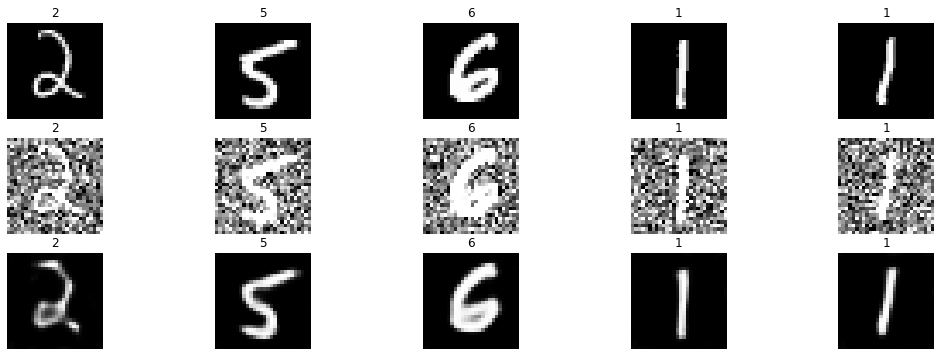

In [ ]:
# Увеличение шума на 10%
def add_noise(tensor,mean=0.5,std=0.3):
    tensor_with_noise = tensor + torch.empty(tensor.shape).normal_(mean=mean,std=std)
    return torch.clip(tensor_with_noise,min = 0, max = 1)
check_model_work(noise_model.cpu(),testloader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


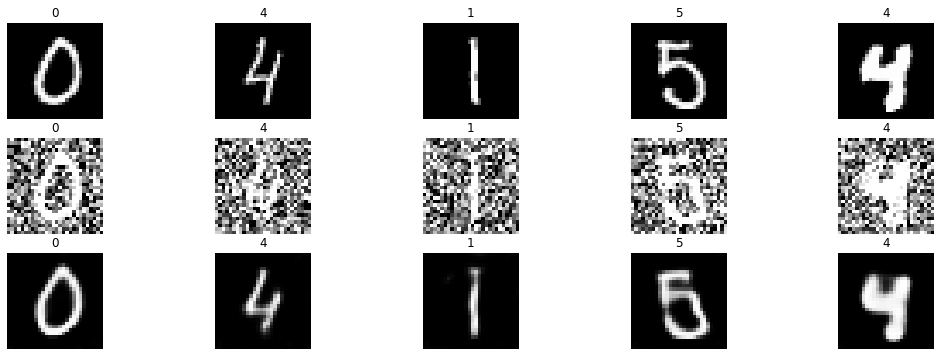

In [ ]:
# Увеличение шума на 10%
def add_noise(tensor,mean=0.5,std=0.4):
    tensor_with_noise = tensor + torch.empty(tensor.shape).normal_(mean=mean,std=std)
    return torch.clip(tensor_with_noise,min = 0, max = 1)
check_model_work(noise_model.cpu(),testloader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


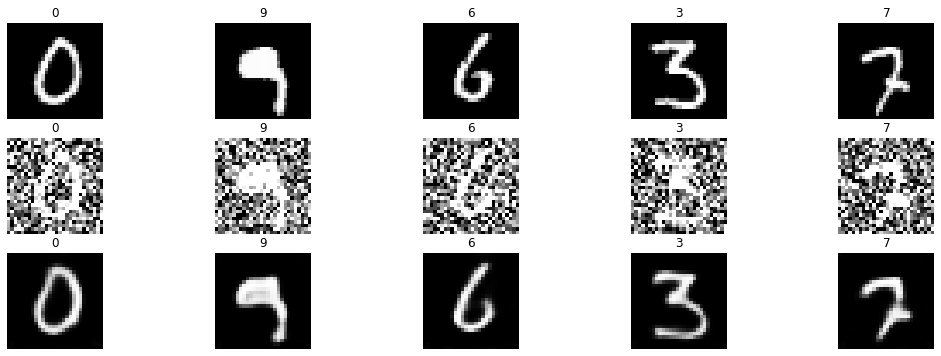

In [ ]:
# Увеличение шума на 10%
def add_noise(tensor,mean=0.5,std=0.5):
    tensor_with_noise = tensor + torch.empty(tensor.shape).normal_(mean=mean,std=std)
    return torch.clip(tensor_with_noise,min = 0, max = 1)
check_model_work(noise_model.cpu(),testloader)

Выйдем за границы разумного увеличения шума (до данного пункта шум добавлялся из нормального распределения со мат ожиданием 0.5 и стандартным отклонением от 0.3 до 0.5 (3 последних запуска модели). В данном случае попробуем поменять мат ожидание

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


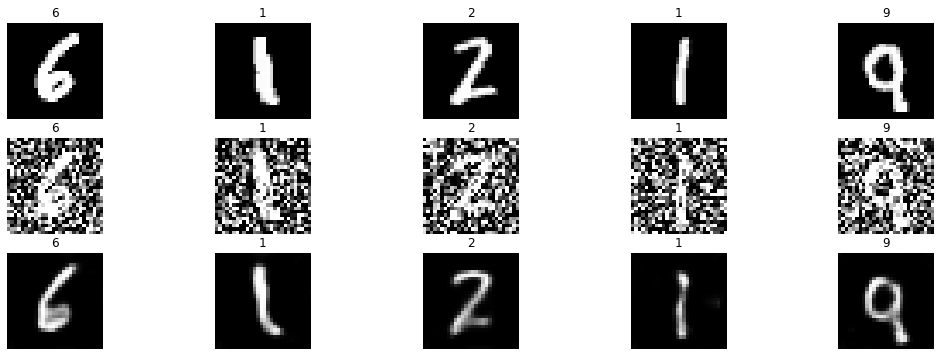

In [ ]:
# мат ожидание 0.3, стандартное отклонение 0.6
def add_noise(tensor,mean=0.3,std=0.6):
    tensor_with_noise = tensor + torch.empty(tensor.shape).normal_(mean=mean,std=std)
    return torch.clip(tensor_with_noise,min = 0, max = 1)
check_model_work(noise_model.cpu(),testloader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


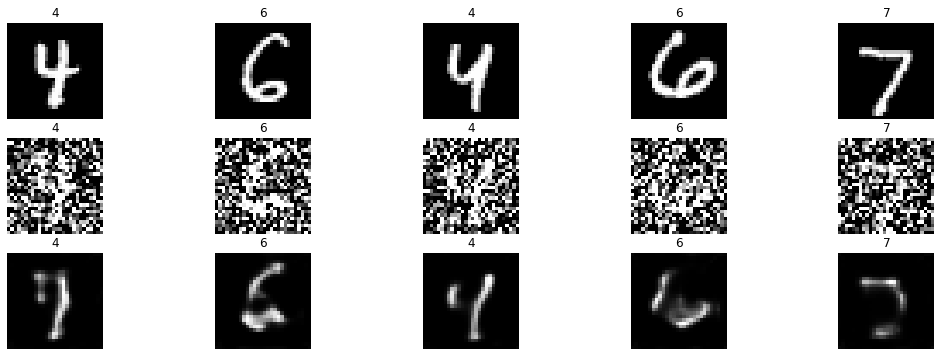

In [ ]:
# мат ожидание 0.2, стандартное отклонение 0.8
def add_noise(tensor,mean=0.2,std=0.8):
    tensor_with_noise = tensor + torch.empty(tensor.shape).normal_(mean=mean,std=std)
    return torch.clip(tensor_with_noise,min = 0, max = 1)
check_model_work(noise_model.cpu(),testloader)

Видим, что модель научилась находить закономерности и неплохо восстанавливает данные, если шум на входе в пределах размуного. В случае, когда мат ожидание было 0.2, а стандартное отклонение 0.8, то ответы расплывчаты, но и человеку сложно найти в зашумленном изображении число.

Denoising AutoEncoder для гладкой функции (например sin)

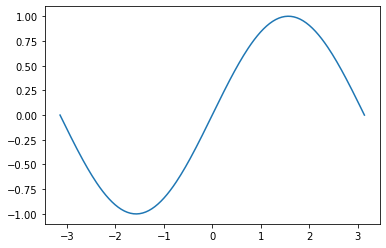

200

In [29]:
x = np.linspace(-np.pi, np.pi,200)
sin = np.sin(x)
plt.plot(x,sin)
plt.show()
len(sin)

In [5]:
class Sin_Encoder(nn.Module):
  def __init__(self):
        super(Sin_Encoder, self).__init__()

        #Encoder
        self.Encoder = nn.Sequential(nn.Linear(200,150),
                                     nn.ReLU(),
                                     nn.Linear(150,100),
                                     nn.ReLU(),
                                     nn.Linear(100,64),
                                     nn.ReLU())
        
        self.code = nn.Sequential(nn.Linear(64,64),
                                  nn.Sigmoid())

        #Decoder
        self.Decoder = nn.Sequential(nn.Linear(64,100),
                                     nn.Tanh(),
                                     nn.Linear(100,150),
                                     nn.Tanh(),
                                     nn.Linear(150,200),
                                     nn.Tanh())        


  def forward(self,x):
      x = torch.tensor(x,dtype = torch.float)
      x = self.Encoder(x)
      x = self.code(x)
      x = self.Decoder(x)
      return x

In [6]:
def train_mode(model, criterion, optim, loader):
  train_loss = 0
  model.train()

  for data in loader:
    optim.zero_grad()
    pred = model(data)
    loss = criterion(pred,torch.tensor(data,dtype=torch.float))
    loss.backward()
    optim.step()
    train_loss += loss.item()
  return train_loss

def test_mode(model, criterion, loader):
  test_loss = 0
  model.eval()
  for data in loader:
    data = data.to(device)
    with torch.set_grad_enabled(False):
      pred = model(data)
      loss = criterion(pred,data)
    test_loss += loss.item() 
    
  return test_loss
  

In [43]:
trainloader = testloader =  torch.utils.data.DataLoader(torch.tensor(sin, dtype = torch.float).unsqueeze(0))
device = torch.device("cpu")
print(device)

cpu


iteration number:1
train loss: 0.51798 | test loss: 0.50295
iteration number:2
train loss: 0.50295 | test loss: 0.48843
iteration number:3
train loss: 0.48843 | test loss: 0.47426
iteration number:4
train loss: 0.47426 | test loss: 0.46029
iteration number:5
train loss: 0.46029 | test loss: 0.44637
iteration number:6
train loss: 0.44637 | test loss: 0.43239
iteration number:7
train loss: 0.43239 | test loss: 0.41822
iteration number:8
train loss: 0.41822 | test loss: 0.40378
iteration number:9
train loss: 0.40378 | test loss: 0.38901
iteration number:10
train loss: 0.38901 | test loss: 0.37384
iteration number:11
train loss: 0.37384 | test loss: 0.35827
iteration number:12
train loss: 0.35827 | test loss: 0.34226
iteration number:13
train loss: 0.34226 | test loss: 0.32585
iteration number:14
train loss: 0.32585 | test loss: 0.30906
iteration number:15
train loss: 0.30906 | test loss: 0.29195


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


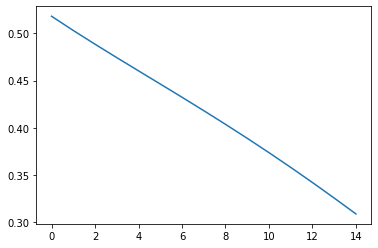

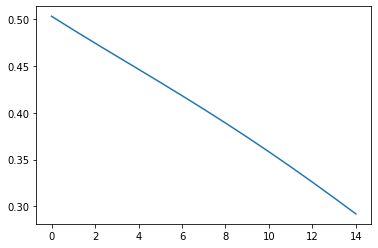

In [44]:
model = Sin_Encoder()
optimizer = torch.optim.Adam(model.parameters(),lr = 3e-4)
loss_func = nn.MSELoss()
hist = loop(model.to(device),loss_func, optimizer, trainloader,testloader,15)
show_graph(hist)

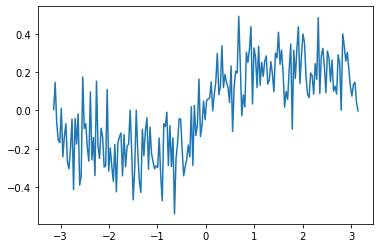

In [45]:
plt.plot(x,model(sin).detach())
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


iteration number:1
train loss: 0.29195 | test loss: 0.27459
iteration number:2
train loss: 0.27459 | test loss: 0.25706
iteration number:3
train loss: 0.25706 | test loss: 0.23946
iteration number:4
train loss: 0.23946 | test loss: 0.22191
iteration number:5
train loss: 0.22191 | test loss: 0.20454
iteration number:6
train loss: 0.20454 | test loss: 0.18749
iteration number:7
train loss: 0.18749 | test loss: 0.17089
iteration number:8
train loss: 0.17089 | test loss: 0.15487
iteration number:9
train loss: 0.15487 | test loss: 0.13956
iteration number:10
train loss: 0.13956 | test loss: 0.12505
iteration number:11
train loss: 0.12505 | test loss: 0.11146
iteration number:12
train loss: 0.11146 | test loss: 0.09885
iteration number:13
train loss: 0.09885 | test loss: 0.08727
iteration number:14
train loss: 0.08727 | test loss: 0.07674
iteration number:15
train loss: 0.07674 | test loss: 0.06726
iteration number:16
train loss: 0.06726 | test loss: 0.05880
iteration number:17
train loss: 0

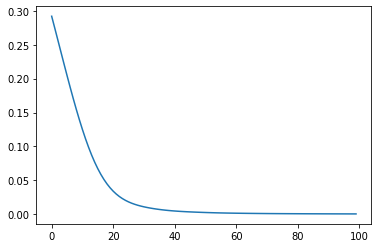

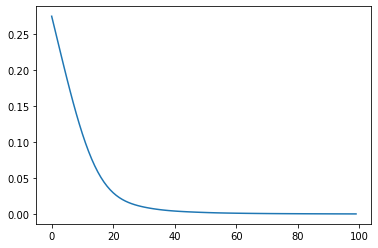

In [46]:
hist = loop(model.to(device),loss_func, optimizer, trainloader,testloader,100)
show_graph(hist)

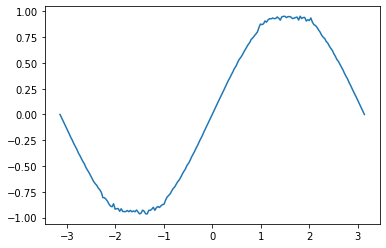

In [47]:
plt.plot(x,model(sin).detach())
plt.show()

In [48]:
def add_noise_sin(sin, mean = 0, std = 0.2):
    # Мат ожидание loc, стандартное отклонение scale
    return torch.tensor(sin + np.random.normal(size = sin.shape, loc = mean, scale = std), dtype=torch.float)

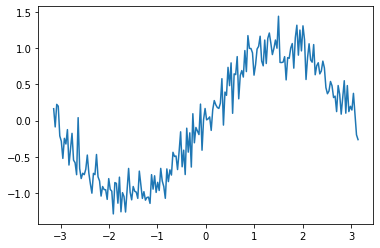

In [49]:
plt.plot(x,add_noise_sin(sin))
plt.show()

In [50]:
def noise_train_mode(model, criterion, optim, loader):
  train_loss = 0
  model.train()
  for data in loader:
    noise_sin = add_noise_sin(data)
    optim.zero_grad()
    pred = model(noise_sin)
    loss = criterion(pred,torch.tensor(data,dtype=torch.float))
    loss.backward()
    optim.step()
    train_loss += loss.item()
  return train_loss

def noise_test_mode(model, criterion, loader):
  test_loss = 0
  model.eval()
  for data in loader:
    noise_sin = add_noise_sin(data)
    with torch.set_grad_enabled(False):
      pred = model(noise_sin)
      loss = criterion(pred,data)
    test_loss += loss.item() 
    
  return test_loss

iteration number:1
train loss: 0.51098 | test loss: 0.49645
iteration number:2
train loss: 0.49645 | test loss: 0.48233
iteration number:3
train loss: 0.48233 | test loss: 0.46852
iteration number:4
train loss: 0.46852 | test loss: 0.45491
iteration number:5
train loss: 0.45491 | test loss: 0.44136
iteration number:6
train loss: 0.44136 | test loss: 0.42777
iteration number:7
train loss: 0.42777 | test loss: 0.41406
iteration number:8
train loss: 0.41406 | test loss: 0.40014
iteration number:9
train loss: 0.40014 | test loss: 0.38594
iteration number:10
train loss: 0.38594 | test loss: 0.37143
iteration number:11
train loss: 0.37143 | test loss: 0.35658
iteration number:12
train loss: 0.35658 | test loss: 0.34137
iteration number:13
train loss: 0.34137 | test loss: 0.32582
iteration number:14
train loss: 0.32582 | test loss: 0.30994
iteration number:15
train loss: 0.30994 | test loss: 0.29377


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


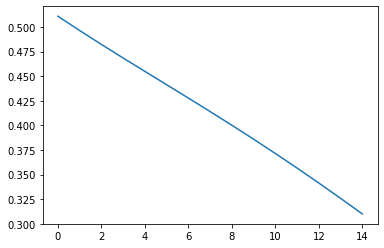

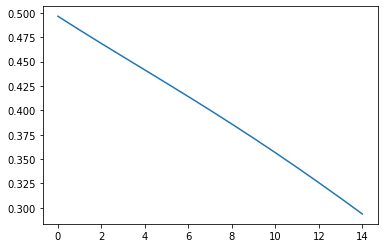

In [51]:
model = Sin_Encoder()
optimizer = torch.optim.Adam(model.parameters(),lr = 3e-4)
loss_func = nn.MSELoss()
hist = loop(model.to(device),loss_func, optimizer, trainloader,testloader,15)
show_graph(hist)

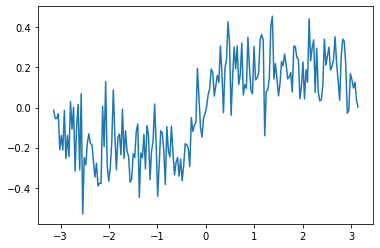

In [52]:
plt.plot(x,model(sin).detach())
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


iteration number:1
train loss: 0.29377 | test loss: 0.27736
iteration number:2
train loss: 0.27736 | test loss: 0.26079
iteration number:3
train loss: 0.26079 | test loss: 0.24412
iteration number:4
train loss: 0.24412 | test loss: 0.22746
iteration number:5
train loss: 0.22746 | test loss: 0.21092
iteration number:6
train loss: 0.21092 | test loss: 0.19462
iteration number:7
train loss: 0.19462 | test loss: 0.17868
iteration number:8
train loss: 0.17868 | test loss: 0.16320
iteration number:9
train loss: 0.16320 | test loss: 0.14831
iteration number:10
train loss: 0.14831 | test loss: 0.13411
iteration number:11
train loss: 0.13411 | test loss: 0.12070
iteration number:12
train loss: 0.12070 | test loss: 0.10814
iteration number:13
train loss: 0.10814 | test loss: 0.09649
iteration number:14
train loss: 0.09649 | test loss: 0.08578
iteration number:15
train loss: 0.08578 | test loss: 0.07602
iteration number:16
train loss: 0.07602 | test loss: 0.06718
iteration number:17
train loss: 0

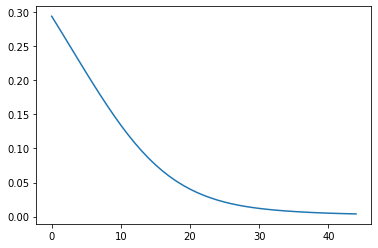

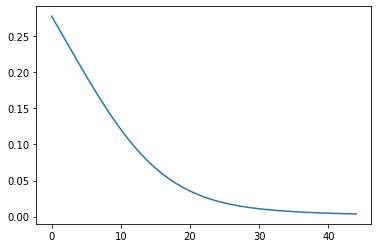

In [53]:
hist = loop(model.to(device),loss_func, optimizer, trainloader,testloader,45)
show_graph(hist)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


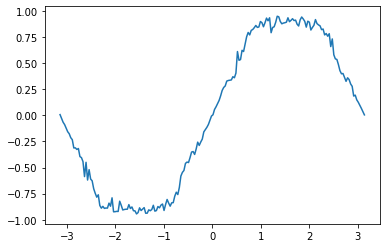

In [54]:
plt.plot(x,model(add_noise_sin(sin)).detach())
plt.show()

In [55]:
hist = loop(model.to(device),loss_func, optimizer, trainloader,testloader,50)

iteration number:1
train loss: 0.00379 | test loss: 0.00360
iteration number:2
train loss: 0.00360 | test loss: 0.00342
iteration number:3
train loss: 0.00342 | test loss: 0.00325
iteration number:4
train loss: 0.00325 | test loss: 0.00309
iteration number:5
train loss: 0.00309 | test loss: 0.00293
iteration number:6
train loss: 0.00293 | test loss: 0.00277
iteration number:7
train loss: 0.00277 | test loss: 0.00262
iteration number:8
train loss: 0.00262 | test loss: 0.00246
iteration number:9
train loss: 0.00246 | test loss: 0.00232
iteration number:10
train loss: 0.00232 | test loss: 0.00219
iteration number:11
train loss: 0.00219 | test loss: 0.00206
iteration number:12
train loss: 0.00206 | test loss: 0.00194
iteration number:13
train loss: 0.00194 | test loss: 0.00184
iteration number:14
train loss: 0.00184 | test loss: 0.00174
iteration number:15
train loss: 0.00174 | test loss: 0.00166
iteration number:16
train loss: 0.00166 | test loss: 0.00158
iteration number:17
train loss: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


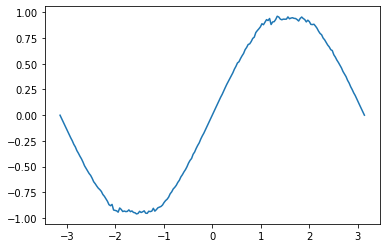

In [56]:
plt.plot(x,model(add_noise_sin(sin)).detach())
plt.show()

In [57]:
hist = loop(model.to(device),loss_func, optimizer, trainloader,testloader,1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


iteration number:1
train loss: 0.00055 | test loss: 0.00054
iteration number:2
train loss: 0.00054 | test loss: 0.00053
iteration number:3
train loss: 0.00053 | test loss: 0.00052
iteration number:4
train loss: 0.00052 | test loss: 0.00051
iteration number:5
train loss: 0.00051 | test loss: 0.00050
iteration number:6
train loss: 0.00050 | test loss: 0.00049
iteration number:7
train loss: 0.00049 | test loss: 0.00048
iteration number:8
train loss: 0.00048 | test loss: 0.00047
iteration number:9
train loss: 0.00047 | test loss: 0.00046
iteration number:10
train loss: 0.00046 | test loss: 0.00046
iteration number:11
train loss: 0.00046 | test loss: 0.00045
iteration number:12
train loss: 0.00045 | test loss: 0.00044
iteration number:13
train loss: 0.00044 | test loss: 0.00043
iteration number:14
train loss: 0.00043 | test loss: 0.00042
iteration number:15
train loss: 0.00042 | test loss: 0.00042
iteration number:16
train loss: 0.00042 | test loss: 0.00041
iteration number:17
train loss: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


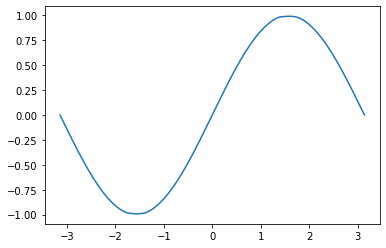

In [58]:
plt.plot(x,model(add_noise_sin(sin)).detach())
plt.show()